# LaminarDB Interactive Exploration

A Jupyter-native walkthrough of LaminarDB's Python API.  
Think of it as a **streaming SQL engine** you can `pip install`.

```bash
pip install laminardb pandas polars plotly
```

In [1]:
import laminardb
from laminardb import ChangeEvent
import pandas as pd
import numpy as np
import time

print(f"LaminarDB {laminardb.__version__}")

LaminarDB 0.12.0


## 1. Connect & Query

Embedded database -- no server, no Docker, no config files.  
Inline SQL queries work out of the box via DataFusion.

In [2]:
db = laminardb.open(":memory:")

# Inline SQL -- renders as an HTML table in Jupyter (_repr_html_)
db.sql("SELECT 42 AS answer, 'hello' AS greeting")

,answer,greeting
0,42,hello


## 2. Create Sources & Load Data

Sources are streaming ingestion points. LaminarDB accepts  
**pandas DataFrames**, **polars DataFrames**, **PyArrow Tables**,  
**dicts**, **JSON strings**, and **CSV strings**.

In [3]:
# Create a source (streaming ingestion point)
db.execute("""
    CREATE SOURCE market_data (
        symbol  VARCHAR,
        price   DOUBLE,
        volume  BIGINT,
        ts      BIGINT
    )
""")

# Generate 10k rows of sample data
np.random.seed(42)
n = 10_000
symbols = np.random.choice(["AAPL", "GOOG", "MSFT", "NVDA"], n)
base_prices = {"AAPL": 185, "GOOG": 175, "MSFT": 415, "NVDA": 875}

sample = pd.DataFrame({
    "symbol": symbols,
    "price": [base_prices[s] * np.exp(np.random.normal(0, 0.02)) for s in symbols],
    "volume": np.random.randint(100, 100_000, n),
    "ts": np.arange(n),
})

# Insert the entire DataFrame -- LaminarDB handles the conversion
rows = db.insert("market_data", sample)
print(f"Inserted {rows:,} rows")
sample.head()

Inserted 10,000 rows


,symbol,price,volume,ts
0,MSFT,410.074575,22513,0
1,NVDA,834.153801,82441,1
2,AAPL,183.481053,85769,2
3,MSFT,422.651514,48999,3
4,MSFT,419.486405,86991,4


## 3. Streaming Queries -- The LaminarDB Difference

Create **continuous queries** that filter or transform data in real time.  
Data flows: `source -> stream -> subscription`.

In [4]:
# Stream 1: Only high-volume trades (> 80,000 shares)
db.execute("""
    CREATE STREAM whale_trades AS
    SELECT symbol, price, volume, ts
    FROM market_data
    WHERE volume > 80000
""")

# Stream 2: All trades pass through (for analytics collection)
db.execute("""
    CREATE STREAM all_trades AS
    SELECT symbol, price, volume, ts
    FROM market_data
""")

# Start the streaming pipeline
db.start()
print("Pipeline started!")
print(f"Sources: {db.tables()}")
print(f"Streams: {db.materialized_views()}")

Pipeline started!
Sources: ['market_data']
Streams: ['whale_trades', 'all_trades']


## 4. Real-Time Subscriptions

Subscribe to streaming data. New data is pushed to your callback in real time.  
No polling. No batch queries. Just events.

In [5]:
# Collect whale trades and all trades via subscriptions
whale_data = []
all_data = []

mv_whale = laminardb.mv(db, "whale_trades")
mv_all = laminardb.mv(db, "all_trades")

def on_whale(event: ChangeEvent):
    for row in event:
        whale_data.append(row.to_dict())

def on_all(event: ChangeEvent):
    for row in event:
        all_data.append(row.to_dict())

t1 = mv_whale.subscribe(handler=on_whale)
t2 = mv_all.subscribe(handler=on_all)

# Insert more data and let subscriptions collect
for i in range(5):
    batch = pd.DataFrame({
        "symbol": np.random.choice(["AAPL", "GOOG", "MSFT", "NVDA"], 200),
        "price": np.random.lognormal(5, 0.3, 200),
        "volume": np.random.randint(100, 100_000, 200),
        "ts": np.arange(n + i * 200, n + (i + 1) * 200),
    })
    db.insert("market_data", batch)
    time.sleep(0.1)

time.sleep(0.5)  # Let subscriptions drain

print(f"Collected {len(all_data):,} trades via all_trades stream")
print(f"Collected {len(whale_data)} whale trades (volume > 80k)")

# Show some whale trades
if whale_data:
    print("\nSample whale trades:")
    for t in whale_data[:5]:
        print(f"  {t['symbol']:>5s}  ${t['price']:.2f}  vol={t['volume']:,}")

Collected 11,000 trades via all_trades stream
Collected 2142 whale trades (volume > 80k)

Sample whale trades:
   NVDA  $892.50  vol=97,352
   NVDA  $855.00  vol=98,663
   MSFT  $397.08  vol=91,167
   GOOG  $174.08  vol=95,424
   GOOG  $177.47  vol=95,847


## 5. Multi-Format Output

Query results and subscription data can be exported to pandas, polars,  
PyArrow, or plain dicts. Inline SQL works for ad-hoc queries.

In [6]:
# Inline SQL with multiple output formats
result = db.sql("""
    SELECT * FROM (VALUES
        ('AAPL', 185.50, 12000),
        ('GOOG', 175.20, 8000),
        ('MSFT', 415.00, 35000),
        ('NVDA', 875.00, 42000)
    ) AS t(symbol, price, volume)
""")

print("=== .fetchall() ===")
print(result.fetchall())

print("\n=== .to_dicts() ===")
print(result.to_dicts())

print(f"\nlen={len(result)}, columns={result.columns}")

=== .fetchall() ===
[('AAPL', 185.5, 12000), ('GOOG', 175.2, 8000), ('MSFT', 415.0, 35000), ('NVDA', 875.0, 42000)]

=== .to_dicts() ===
{'symbol': ['AAPL', 'GOOG', 'MSFT', 'NVDA'], 'price': [185.5, 175.2, 415.0, 875.0], 'volume': [12000, 8000, 35000, 42000]}

len=4, columns=['symbol', 'price', 'volume']


In [7]:
# .df() -> pandas DataFrame
print("=== .df() -> pandas ===")
display(result.df())

=== .df() -> pandas ===


,symbol,price,volume
0,AAPL,185.5,12000
1,GOOG,175.2,8000
2,MSFT,415.0,35000
3,NVDA,875.0,42000


In [8]:
# .pl() -> polars DataFrame
try:
    import polars as pl

    print("=== .pl() -> polars ===")
    display(result.pl())

    # Polars lazy evaluation on subscription data
    if all_data:
        print("\n=== Polars lazy group_by on subscription data ===")
        lazy_result = (
            pl.DataFrame(all_data)
            .lazy()
            .filter(pl.col("volume") > 50_000)
            .group_by("symbol")
            .agg([
                pl.col("price").mean().alias("avg_price"),
                pl.col("volume").sum().alias("total_volume"),
                pl.col("volume").count().alias("count"),
            ])
            .sort("total_volume", descending=True)
            .collect()
        )
        display(lazy_result)
except ImportError:
    print("(polars not installed)")

=== .pl() -> polars ===


symbol,price,volume
str,f64,i64
"""AAPL""",185.5,12000
"""GOOG""",175.2,8000
"""MSFT""",415.0,35000
"""NVDA""",875.0,42000



=== Polars lazy group_by on subscription data ===


symbol,avg_price,total_volume,count
str,f64,i64,u32
"""NVDA""",808.235916,106158878,1415
"""MSFT""",391.292276,103942199,1393
"""GOOG""",173.806188,103002349,1383
"""AAPL""",182.459531,101171768,1345


In [9]:
# .arrow() -> PyArrow Table
try:
    arrow_table = result.arrow()
    print("=== .arrow() -> PyArrow Table ===")
    print(arrow_table)
    print(f"\nSchema: {arrow_table.schema}")
except ImportError:
    print("(pyarrow not installed)")

=== .arrow() -> PyArrow Table ===
pyarrow.Table
symbol: string
price: double
volume: int64
----
symbol: [["AAPL","GOOG","MSFT","NVDA"]]
price: [[185.5,175.2,415,875]]
volume: [[12000,8000,35000,42000]]

Schema: symbol: string
price: double
volume: int64


## 6. Plotly Visualization

Visualize subscription-collected data with Plotly.

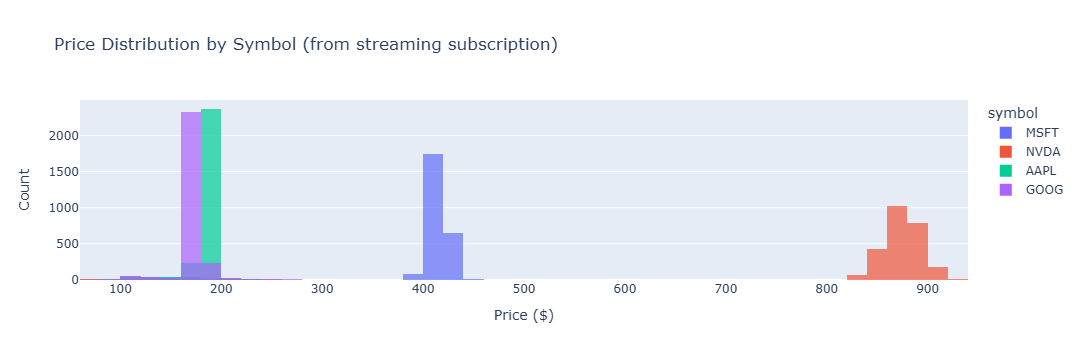

In [10]:
try:
    import plotly.express as px

    if all_data:
        price_df = pd.DataFrame(all_data)

        fig = px.histogram(
            price_df,
            x="price",
            color="symbol",
            nbins=60,
            title="Price Distribution by Symbol (from streaming subscription)",
            barmode="overlay",
            opacity=0.7,
        )
        fig.update_layout(xaxis_title="Price ($)", yaxis_title="Count")
        fig.show()
    else:
        print("No data collected yet")
except ImportError:
    print("(plotly not installed)")

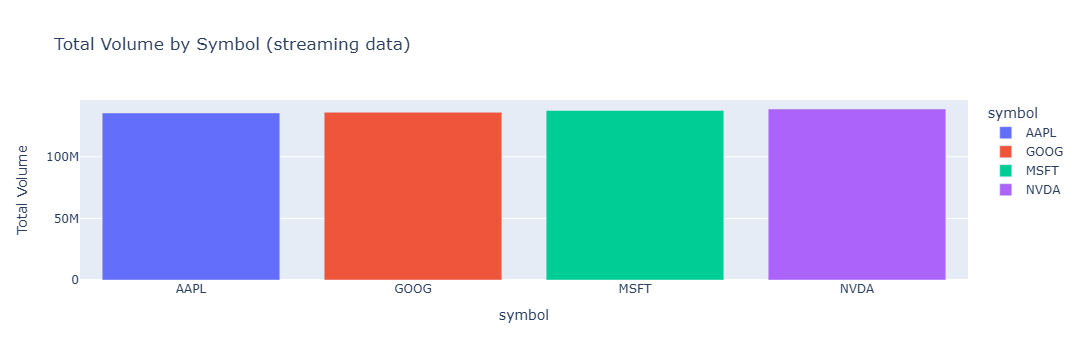

In [11]:
try:
    import plotly.express as px

    if all_data:
        df = pd.DataFrame(all_data)
        # Volume by symbol
        vol_summary = df.groupby("symbol").agg(
            total_volume=("volume", "sum"),
            avg_price=("price", "mean"),
            trade_count=("volume", "count"),
        ).reset_index()

        fig = px.bar(
            vol_summary,
            x="symbol",
            y="total_volume",
            color="symbol",
            title="Total Volume by Symbol (streaming data)",
        )
        fig.update_layout(yaxis_title="Total Volume")
        fig.show()
except ImportError:
    print("(plotly not installed)")

## 7. Schema Introspection

Explore your database catalog -- sources, streams, schemas, and statistics.

In [ ]:
print(f"Sources (tables):       {db.tables()}")
print(f"Streams (materialized): {db.materialized_views()}")
print(f"\nSchema for 'market_data':")
print(db.schema("market_data"))

print(f"\nTable stats:")
print(db.stats("market_data"))

In [ ]:
# Detailed catalog info
print("=== Sources ===")
for src in db.sources():
    print(f"  {src.name}: schema={src.schema}, watermark_col={src.watermark_column}")

print("\n=== Streams ===")
for stream in db.streams():
    print(f"  {stream.name}: sql={stream.sql}")

## 8. Pipeline Metrics & Topology

In [ ]:
m = db.metrics()
print(f"Pipeline state:    {m.state}")
print(f"Events ingested:   {m.total_events_ingested:,}")
print(f"Uptime:            {m.uptime_secs:.1f}s")

print("\n--- Source Metrics ---")
for sm in db.all_source_metrics():
    print(f"  {sm.name}: events={sm.total_events:,}, pending={sm.pending}, watermark={sm.watermark}")

print("\n--- Topology ---")
topo = db.topology()
for node in topo.nodes:
    print(f"  [{node.node_type}] {node.name}")
for edge in topo.edges:
    print(f"    {edge.from_node} --> {edge.to_node}")

## 9. Query Plan

Understand how LaminarDB executes your SQL.

In [ ]:
plan = db.explain("SELECT 1 + 1 AS answer")
print(plan)

## 10. Writer API -- Streaming Inserts

For high-throughput ingestion, use the Writer context manager.

In [ ]:
import random

with db.writer("market_data") as w:
    for i in range(10):
        batch = [
            {
                "symbol": random.choice(["AAPL", "GOOG", "MSFT", "NVDA"]),
                "price": round(random.uniform(100, 900), 2),
                "volume": random.randint(100, 50_000),
                "ts": 300_000 + i * 100 + j,
            }
            for j in range(100)
        ]
        w.insert(batch)

    print(f"Writer source: {w.name}")
    print(f"Writer schema: {w.schema}")
    print(f"Watermark: {w.current_watermark}")

# Let subscriptions pick up the new data
time.sleep(0.5)
print(f"\nTotal trades collected via subscription: {len(all_data):,}")

## Summary

LaminarDB is a **streaming-first** database:

| Concept | How It Works |
|---|---|
| **Sources** | Ingestion points (`CREATE SOURCE`, `insert()`, `writer()`) |
| **Streams** | Continuous SQL queries (`CREATE STREAM ... AS SELECT ... FROM source`) |
| **Subscriptions** | Real-time delivery (`mv.subscribe(handler=)`) |
| **Inline SQL** | Ad-hoc queries via DataFusion (`db.sql("SELECT ...")`) |

Data flows through the pipeline: **source -> stream -> subscription**.  
No Kafka. No Flink. Just `pip install laminardb`.

In [ ]:
db.close()
print("Done!")